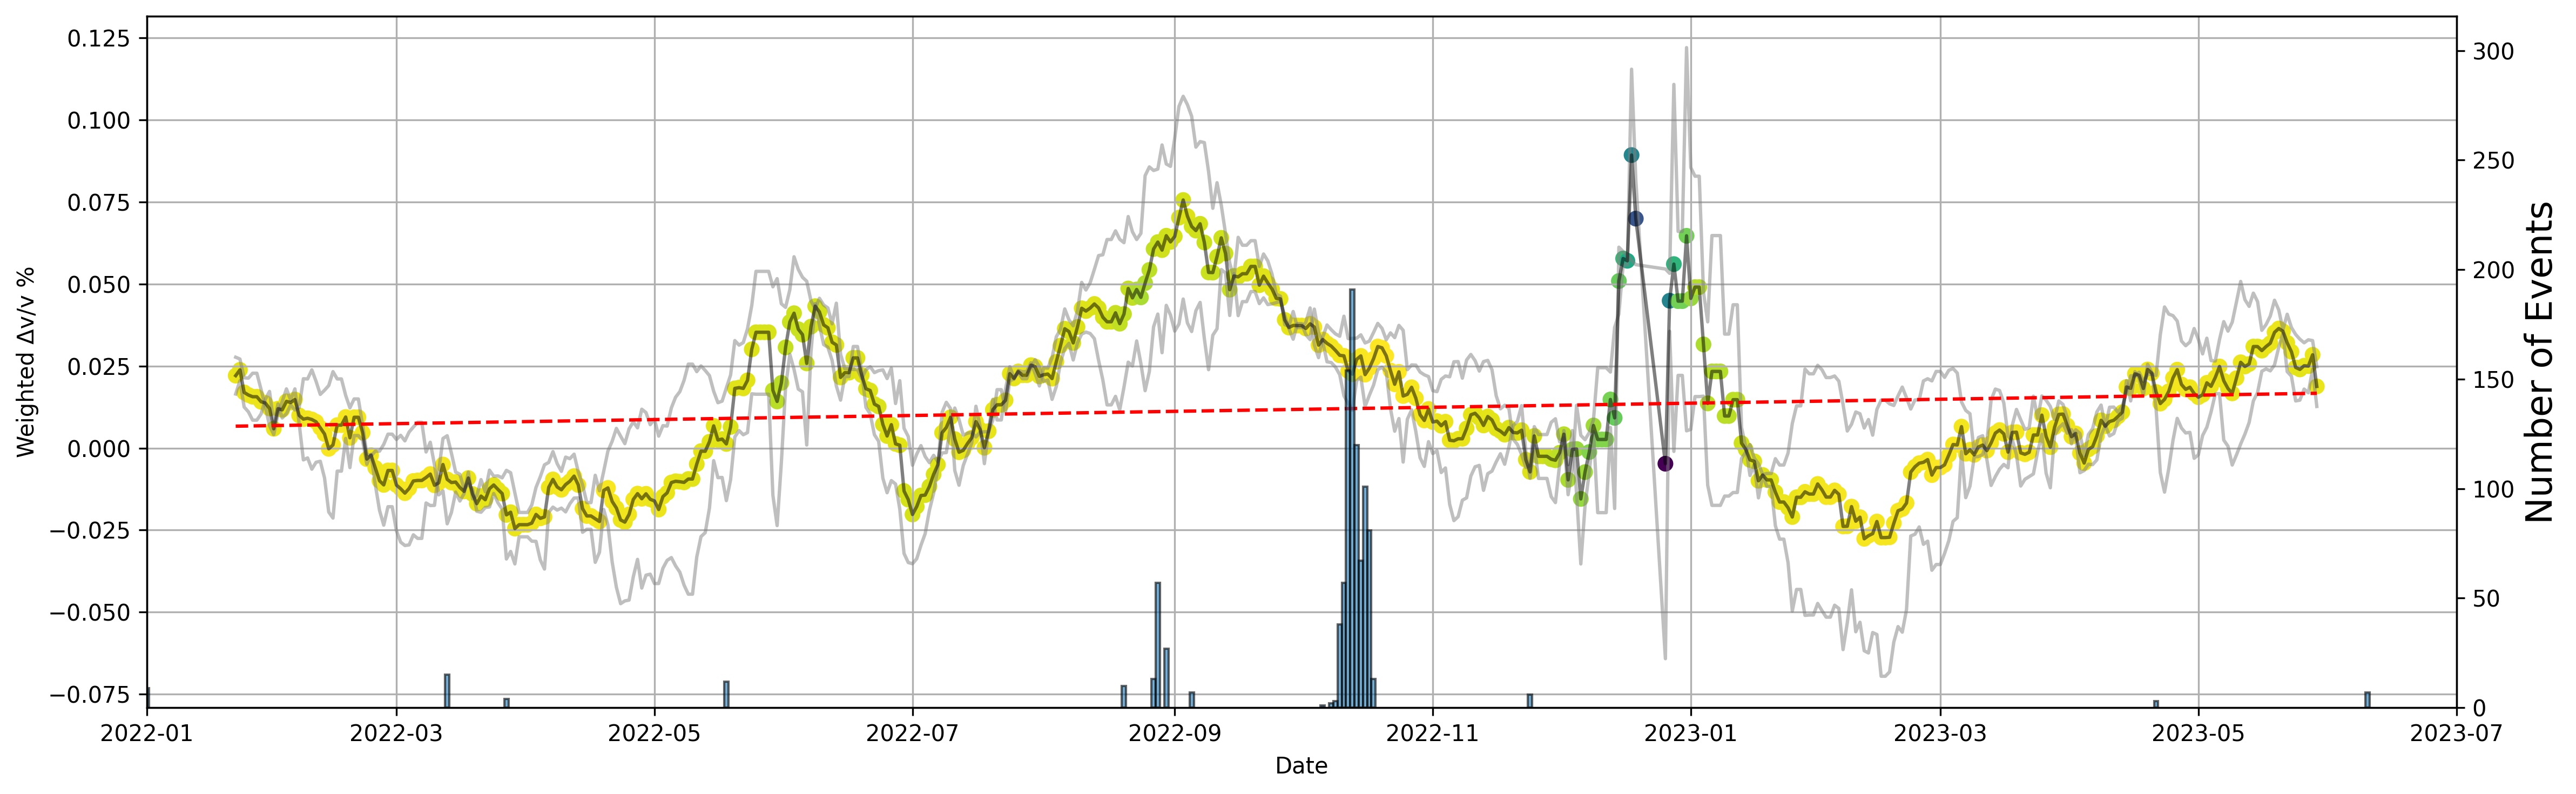

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
#    'HYSB1_add_long_NE_positive_3-5.csv',
#    'HYSB1_add_long_NE_negative_3-5.csv',
    'HYSB1_add_long_ZN_positive_0.5-1.csv',
    'HYSB1_add_long_ZN_negative_0.5-1.csv',
    #'HYSB1_add_long_ZE_negative_0.5-1.csv',
    #'HYSB1_add_long_ZE_positive_0.5-1.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, 1, 1, 1, 1, 1]
filtered_events_path = 'Data/filtered_events_per_day_lat_44.csv'
# Significant event dates
Tdates = [
    '2015-06-24 22:25:29.343674', '2015-10-21 07:10:22.988772', '2016-01-10 21:12:28.836671',
    '2016-02-27 12:03:06.102124', '2016-06-04 14:36:16.085195', '2016-06-04 14:37:36.094455',
    '2016-08-05 16:32:06.889686', '2016-08-14 00:35:30.246556', '2016-08-14 14:38:36.101401',
    '2016-08-20 22:07:09.216344', '2016-09-01 15:43:16.550527', '2016-09-17 02:04:20.863526',
    '2016-09-17 02:08:10.890149', '2016-09-24 18:19:27.635143', '2016-09-25 03:22:01.402940',
    '2016-09-25 03:24:51.422618', '2016-10-02 12:07:35.052668', '2016-11-18 05:22:02.236370',
    '2017-07-29 04:03:41.692326', '2017-09-06 10:28:44.366246', '2017-09-06 13:01:05.424239',
    '2017-09-06 13:13:25.509897', '2017-09-06 13:15:45.526103', '2017-09-06 13:19:15.550411',
    '2017-09-06 13:48:05.750666', '2017-09-06 13:55:55.805070', '2017-09-06 13:58:15.821276',
    '2017-09-06 14:06:35.879153', '2017-09-06 14:10:55.909249', '2017-09-06 14:31:06.049311',
    '2017-09-06 14:47:16.161593', '2017-09-06 15:14:26.350272', '2017-09-06 15:32:06.472971',
    '2017-09-06 16:52:17.029749', '2017-09-06 17:02:57.103831', '2017-09-06 17:04:37.115407',
    '2017-09-06 17:06:47.130455', '2017-09-06 17:37:27.343443', '2018-01-03 15:22:06.403519',
    '2018-02-10 14:43:16.133812', '2018-03-13 15:48:13.211856', '2018-06-26 12:51:25.357102',
    '2018-06-26 13:01:05.424239', '2018-09-19 07:27:03.104526', '2019-05-11 05:18:53.169843',
    '2019-07-11 03:20:01.777251', '2019-07-11 03:32:31.888329', '2019-07-11 03:46:02.008294',
    '2020-05-08 09:41:54.040977', '2020-07-09 09:30:43.963422'
]
datetime_objects = [pd.to_datetime(date) for date in Tdates]

# Load filtered events
filtered_events = pd.read_csv(filtered_events_path, index_col=0, parse_dates=True)


# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Plot
fig, ax1 = plt.subplots(figsize=(16, 5), dpi=300)

# Plot grey traces
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    ax1.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean and weighted Δv/v
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Plot weighted Δv/v
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = unified_index
sc = ax1.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cm.viridis)
ax1.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)

# Trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64) // 10**9
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
ax1.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64) // 10**9), 'r--', label='Trend Line')

# Adding vertical red lines for significant dates
for dt in datetime_objects:
    ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.8)

# Add secondary y-axis for event counts
ax2 = ax1.twinx()
ax2.bar(filtered_events.index, filtered_events['Number of Events'], width=1, edgecolor='black', alpha=0.6, label='Event Count')
ax2.set_ylabel('Number of Events', fontsize=16)
ax2.set_ylim([0, filtered_events['Number of Events'].max() * 1.1])
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-07-01")
ax1.set_xlim([start_date, end_date])    

# Labels, legends, and color bar
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Δv/v %')

#ax1.set_ylim([-0.2, 0.2])
ax1.grid(True)
plt.tight_layout()
plt.show()


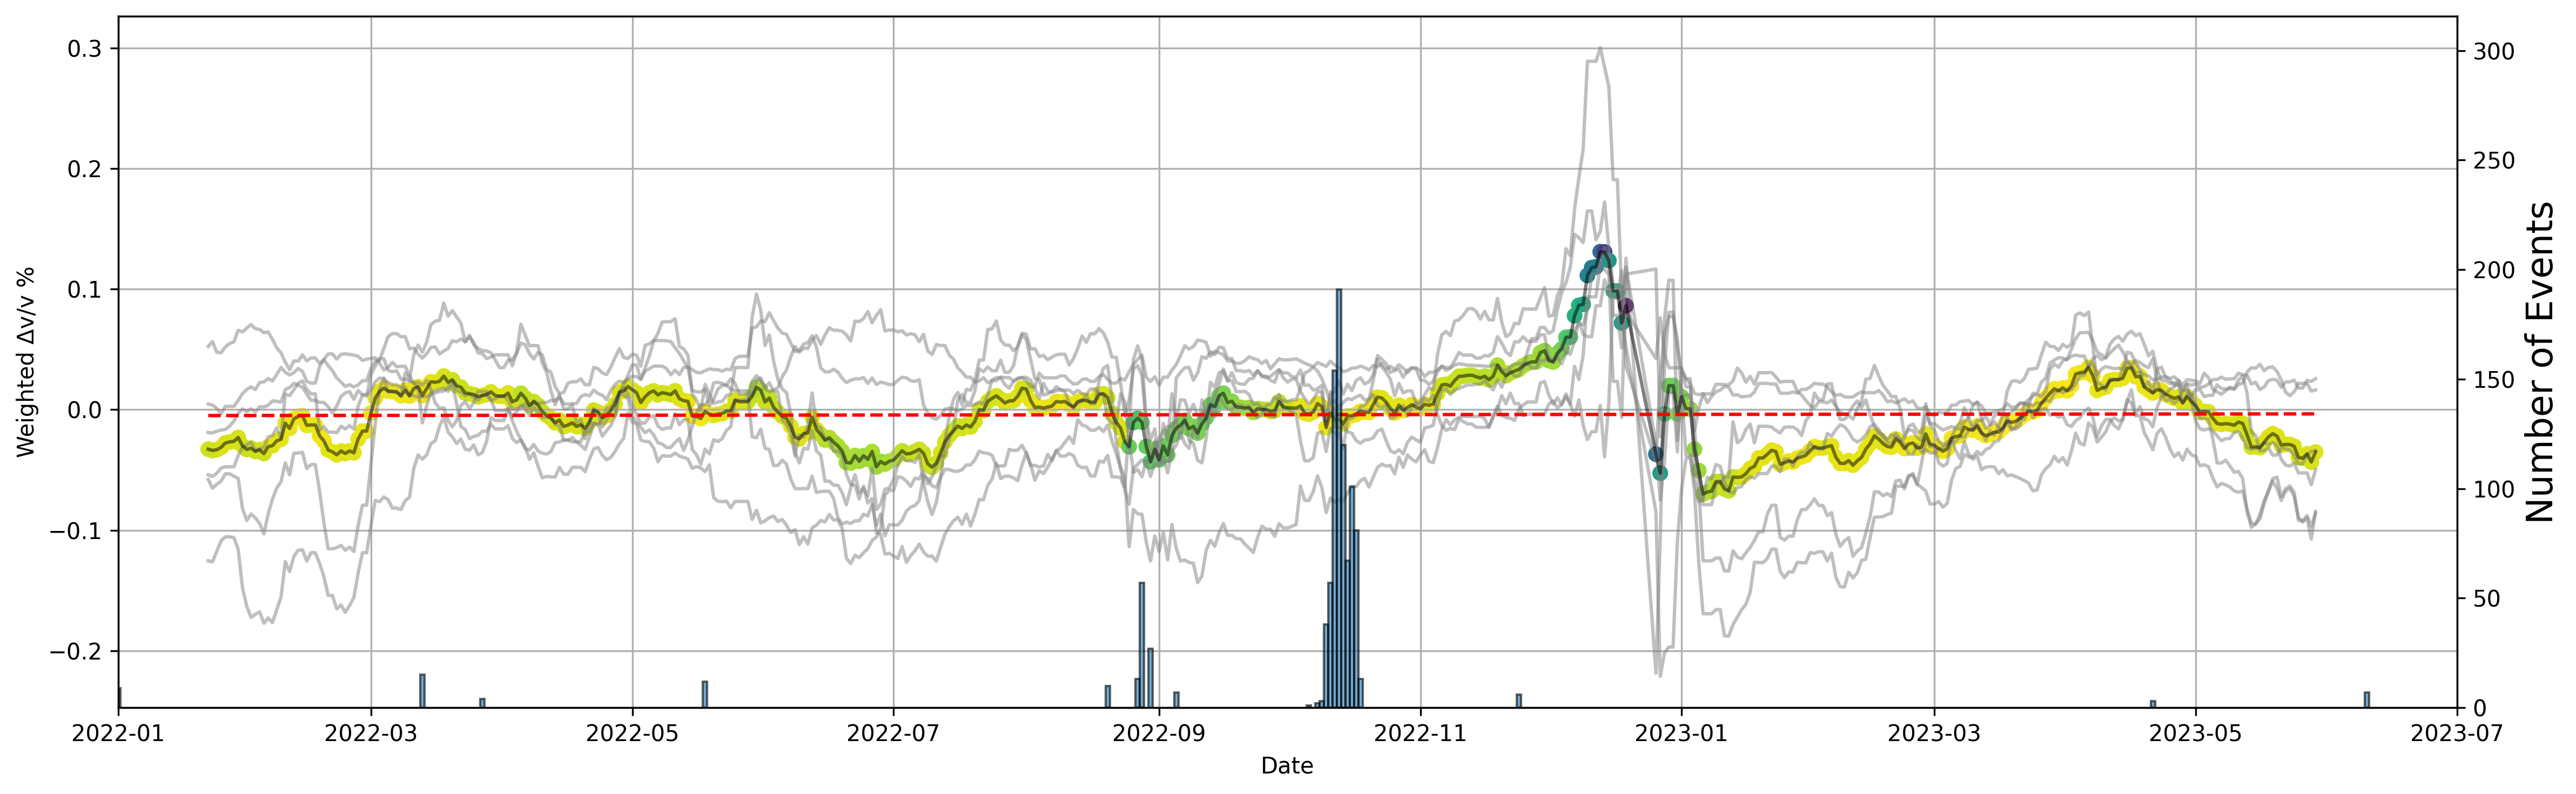

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    'HYSB1_add_long_ZE_positive_1-3.csv',
    'HYSB1_add_long_ZE_negative_1-3.csv',
    'HYSB1_add_long_ZN_positive_1-3.csv',
    'HYSB1_add_long_ZN_negative_1-3.csv',
    'HYSB1_add_long_NE_positive_1-3.csv',
    'HYSB1_add_long_NE_negative_1-3.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, 1, 1, 1, 1, 1]
filtered_events_path = 'Data/filtered_events_per_day_lat_44.csv'
# Significant event dates
Tdates = [
    '2015-06-24 22:25:29.343674', '2015-10-21 07:10:22.988772', '2016-01-10 21:12:28.836671',
    '2016-02-27 12:03:06.102124', '2016-06-04 14:36:16.085195', '2016-06-04 14:37:36.094455',
    '2016-08-05 16:32:06.889686', '2016-08-14 00:35:30.246556', '2016-08-14 14:38:36.101401',
    '2016-08-20 22:07:09.216344', '2016-09-01 15:43:16.550527', '2016-09-17 02:04:20.863526',
    '2016-09-17 02:08:10.890149', '2016-09-24 18:19:27.635143', '2016-09-25 03:22:01.402940',
    '2016-09-25 03:24:51.422618', '2016-10-02 12:07:35.052668', '2016-11-18 05:22:02.236370',
    '2017-07-29 04:03:41.692326', '2017-09-06 10:28:44.366246', '2017-09-06 13:01:05.424239',
    '2017-09-06 13:13:25.509897', '2017-09-06 13:15:45.526103', '2017-09-06 13:19:15.550411',
    '2017-09-06 13:48:05.750666', '2017-09-06 13:55:55.805070', '2017-09-06 13:58:15.821276',
    '2017-09-06 14:06:35.879153', '2017-09-06 14:10:55.909249', '2017-09-06 14:31:06.049311',
    '2017-09-06 14:47:16.161593', '2017-09-06 15:14:26.350272', '2017-09-06 15:32:06.472971',
    '2017-09-06 16:52:17.029749', '2017-09-06 17:02:57.103831', '2017-09-06 17:04:37.115407',
    '2017-09-06 17:06:47.130455', '2017-09-06 17:37:27.343443', '2018-01-03 15:22:06.403519',
    '2018-02-10 14:43:16.133812', '2018-03-13 15:48:13.211856', '2018-06-26 12:51:25.357102',
    '2018-06-26 13:01:05.424239', '2018-09-19 07:27:03.104526', '2019-05-11 05:18:53.169843',
    '2019-07-11 03:20:01.777251', '2019-07-11 03:32:31.888329', '2019-07-11 03:46:02.008294',
    '2020-05-08 09:41:54.040977', '2020-07-09 09:30:43.963422'
]
datetime_objects = [pd.to_datetime(date) for date in Tdates]

# Load filtered events
filtered_events = pd.read_csv(filtered_events_path, index_col=0, parse_dates=True)


# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Plot
fig, ax1 = plt.subplots(figsize=(16, 5), dpi=300)

# Plot grey traces
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    ax1.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean and weighted Δv/v
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Plot weighted Δv/v
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = unified_index
sc = ax1.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cm.viridis)
ax1.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)

# Trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64) // 10**9
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
ax1.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64) // 10**9), 'r--', label='Trend Line')

# Adding vertical red lines for significant dates
for dt in datetime_objects:
    ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.8)

# Add secondary y-axis for event counts
ax2 = ax1.twinx()
ax2.bar(filtered_events.index, filtered_events['Number of Events'], width=1, edgecolor='black', alpha=0.6, label='Event Count')
ax2.set_ylabel('Number of Events', fontsize=16)
ax2.set_ylim([0, filtered_events['Number of Events'].max() * 1.1])
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-07-01")
ax1.set_xlim([start_date, end_date])    

# Labels, legends, and color bar
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Δv/v %')

#ax1.set_ylim([-0.1, 0.1])
ax1.grid(True)
plt.tight_layout()
plt.show()


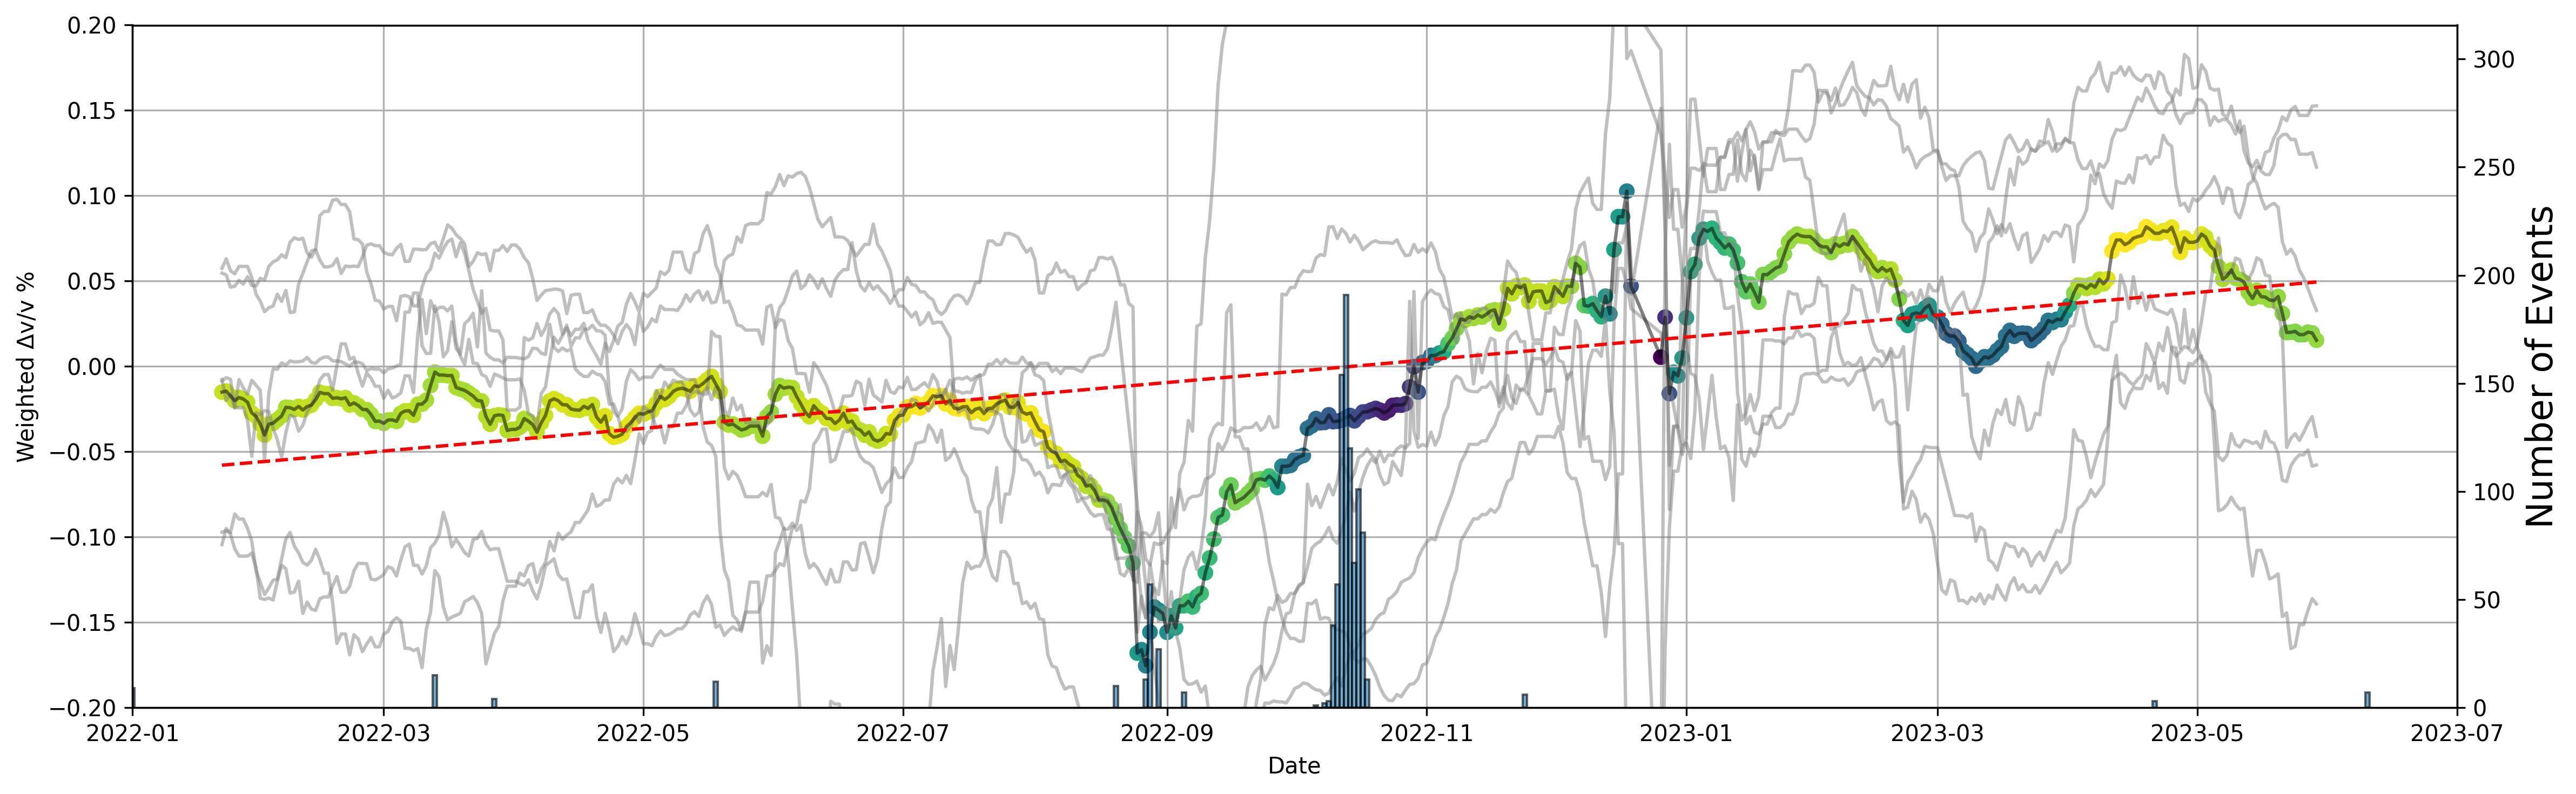

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    'HYSB1_add_long_NE_positive_3-5.csv',
    'HYSB1_add_long_NE_negative_3-5.csv',
    'HYSB1_add_long_ZN_positive_3-5.csv',
    'HYSB1_add_long_ZN_negative_3-5.csv',
    'HYSB1_add_long_ZE_negative_3-5.csv',
    'HYSB1_add_long_ZE_positive_3-5.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, 1, 1, 1, 1, 1]
filtered_events_path = 'Data/filtered_events_per_day_lat_44.csv'
# Significant event dates
Tdates = [
    '2015-06-24 22:25:29.343674', '2015-10-21 07:10:22.988772', '2016-01-10 21:12:28.836671',
    '2016-02-27 12:03:06.102124', '2016-06-04 14:36:16.085195', '2016-06-04 14:37:36.094455',
    '2016-08-05 16:32:06.889686', '2016-08-14 00:35:30.246556', '2016-08-14 14:38:36.101401',
    '2016-08-20 22:07:09.216344', '2016-09-01 15:43:16.550527', '2016-09-17 02:04:20.863526',
    '2016-09-17 02:08:10.890149', '2016-09-24 18:19:27.635143', '2016-09-25 03:22:01.402940',
    '2016-09-25 03:24:51.422618', '2016-10-02 12:07:35.052668', '2016-11-18 05:22:02.236370',
    '2017-07-29 04:03:41.692326', '2017-09-06 10:28:44.366246', '2017-09-06 13:01:05.424239',
    '2017-09-06 13:13:25.509897', '2017-09-06 13:15:45.526103', '2017-09-06 13:19:15.550411',
    '2017-09-06 13:48:05.750666', '2017-09-06 13:55:55.805070', '2017-09-06 13:58:15.821276',
    '2017-09-06 14:06:35.879153', '2017-09-06 14:10:55.909249', '2017-09-06 14:31:06.049311',
    '2017-09-06 14:47:16.161593', '2017-09-06 15:14:26.350272', '2017-09-06 15:32:06.472971',
    '2017-09-06 16:52:17.029749', '2017-09-06 17:02:57.103831', '2017-09-06 17:04:37.115407',
    '2017-09-06 17:06:47.130455', '2017-09-06 17:37:27.343443', '2018-01-03 15:22:06.403519',
    '2018-02-10 14:43:16.133812', '2018-03-13 15:48:13.211856', '2018-06-26 12:51:25.357102',
    '2018-06-26 13:01:05.424239', '2018-09-19 07:27:03.104526', '2019-05-11 05:18:53.169843',
    '2019-07-11 03:20:01.777251', '2019-07-11 03:32:31.888329', '2019-07-11 03:46:02.008294',
    '2020-05-08 09:41:54.040977', '2020-07-09 09:30:43.963422'
]
datetime_objects = [pd.to_datetime(date) for date in Tdates]

# Load filtered events
filtered_events = pd.read_csv(filtered_events_path, index_col=0, parse_dates=True)


# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Plot
fig, ax1 = plt.subplots(figsize=(16, 5), dpi=300)

# Plot grey traces
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    ax1.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean and weighted Δv/v
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Plot weighted Δv/v
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = unified_index
sc = ax1.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cm.viridis)
ax1.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)

# Trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64) // 10**9
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
ax1.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64) // 10**9), 'r--', label='Trend Line')

# Adding vertical red lines for significant dates
for dt in datetime_objects:
    ax1.axvline(x=dt, color='red', linestyle='--', alpha=0.8)

# Add secondary y-axis for event counts
ax2 = ax1.twinx()
ax2.bar(filtered_events.index, filtered_events['Number of Events'], width=1, edgecolor='black', alpha=0.6, label='Event Count')
ax2.set_ylabel('Number of Events', fontsize=16)
ax2.set_ylim([0, filtered_events['Number of Events'].max() * 1.1])
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-07-01")
ax1.set_xlim([start_date, end_date])    

# Labels, legends, and color bar
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Δv/v %')

ax1.set_ylim([-0.2, 0.2])
ax1.grid(True)
plt.tight_layout()
plt.show()


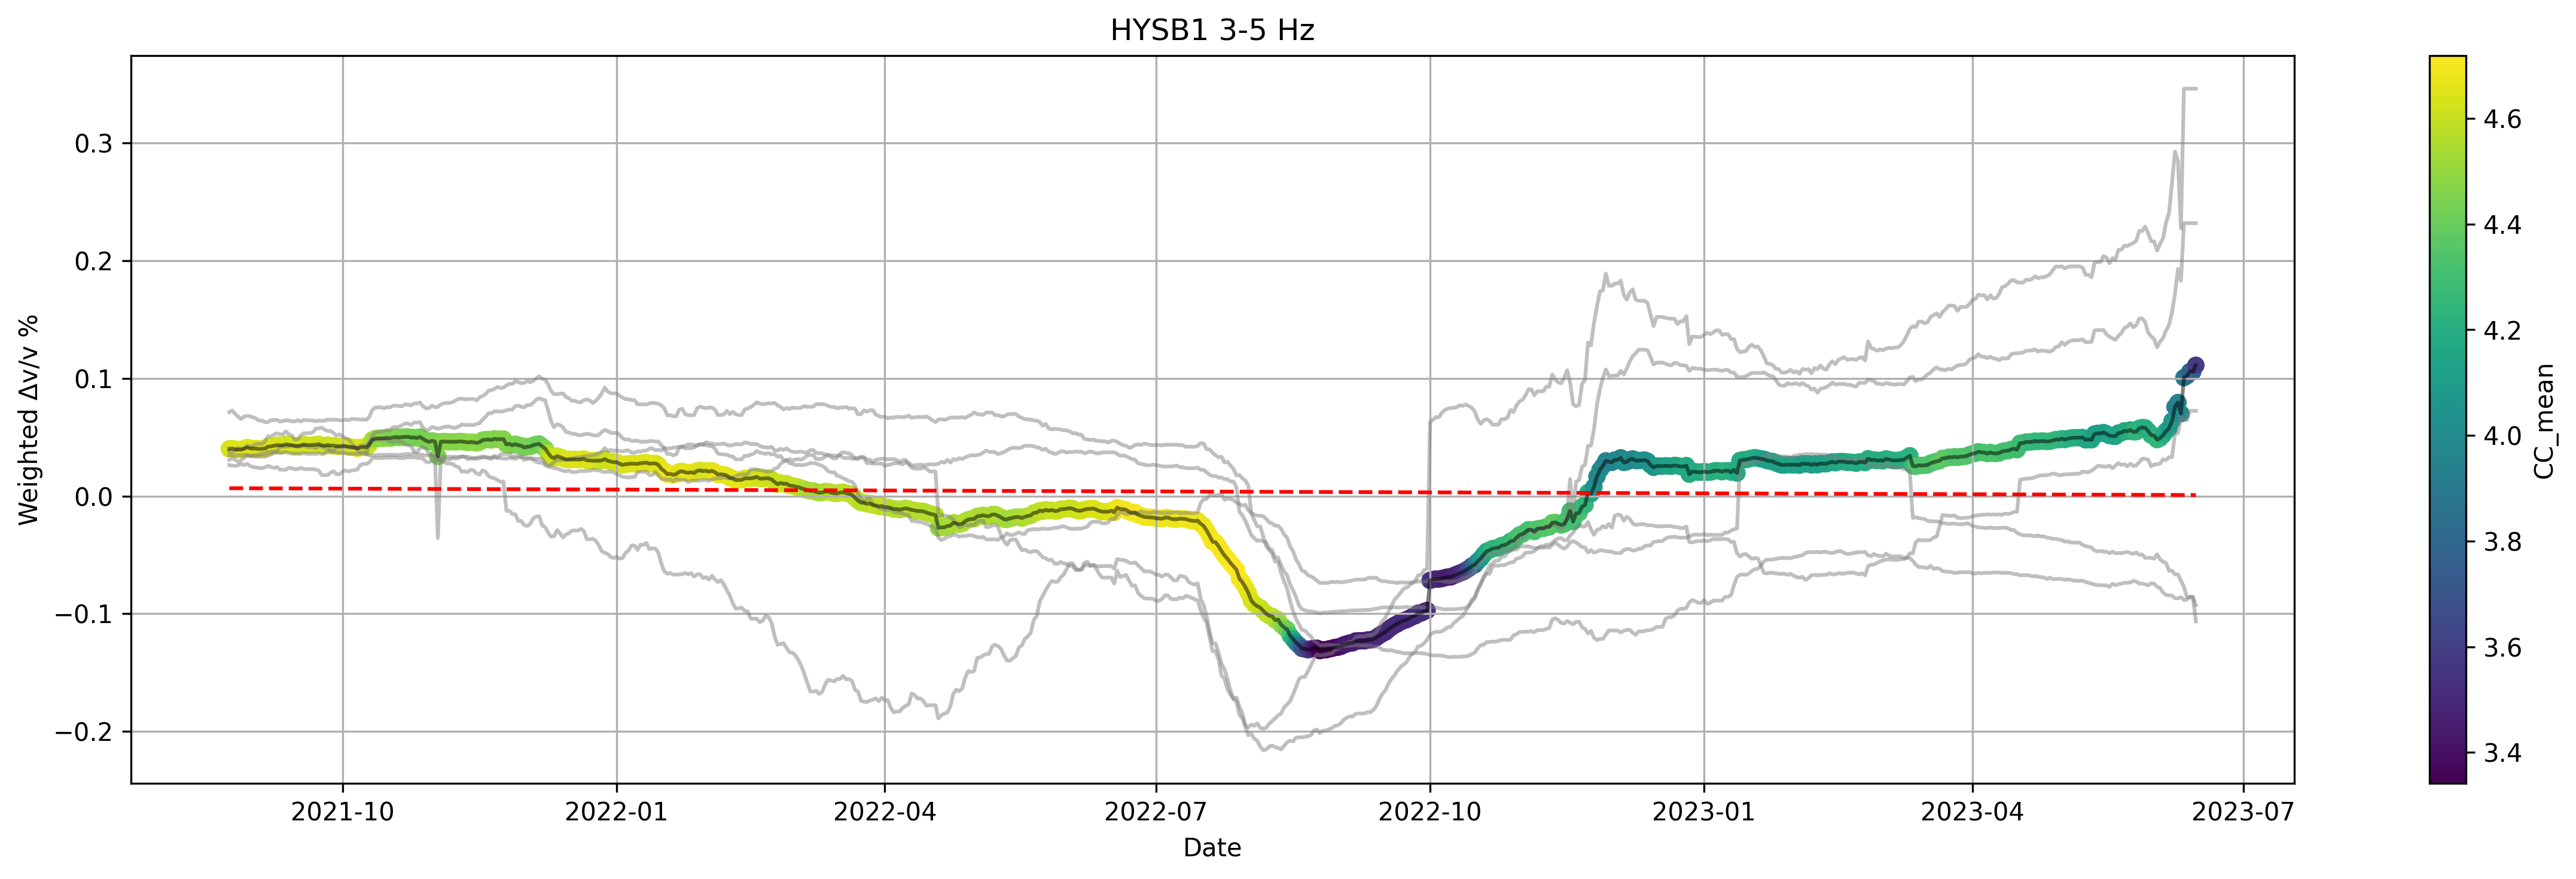

In [14]:
# import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    'Data/HYSB1_addonNE_negative.csv',
    'Data/HYSB1_addonZE_positive.csv',
    'Data/HYSB1_addonZN_negative.csv',
    'Data/HYSB1_addonZN_positive.csv',
    'Data/HYSB1_addonNE_positive.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, 1, 1, 1, 1]

# Read and process dataframes
dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    dataframes.append(df)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Shift the grey individual timeseries by 20 days and plot them
plt.figure(figsize=(16, 5), dpi=300)
for df in interpolated_dfs:
    shifted_df = df.copy()
    shifted_df.index = shifted_df.index + pd.DateOffset(days=0)
    plt.plot(shifted_df.index, shifted_df['DVT'], color='grey', alpha=0.5)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=0)

# Plotting the weighted Δv/v time series with color-coded CC_mean
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')

# Adding a trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64)
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-07-01")
ax1.set_xlim([start_date, end_date])  
# Add labels and legend
plt.xlabel('Date')
#plt.ylim([-0.15, 0.1])
plt.title('HYSB1 3-5 Hz')
plt.ylabel('Weighted Δv/v %')
plt.grid(True)
plt.tight_layout()
plt.show()

HYSB1_35 = weighted_dvv_df
